## **4. Feature Extraction/ Embedding Function**

4.1 To minimized the loading time of the code, we started a new notebook to apply vectorization.

In [1]:
import pandas as pd
train_ready = pd.read_csv("train_ready.csv")
test_ready = pd.read_csv("test_ready.csv")
val_ready  = pd.read_csv("validation_ready.csv")
train_proc = train_ready
test_proc  = test_ready
val_proc   = val_ready

In [2]:
assert "text_clean" in train_proc.columns, "Expected column 'text_clean' not found"
assert "label" in train_proc.columns, "Expected column 'label' not found"

In [3]:
len(val_ready)

4956

4.2 I had some "NaN" values that NLPs can´t read, therefore, I had to do a clean-up process before the vectorization

In [5]:

def sanitize_split(df, split_name):
    # 1) Make sure the column exists
    assert "text_clean" in df.columns, f"{split_name}: 'text_clean' column missing"
    assert "label" in df.columns, f"{split_name}: 'label' column missing"

    # 2) Replace NaN with empty string, ensure type is str, and trim
    df["text_clean"] = df["text_clean"].fillna("").astype(str).str.strip()

    # 3) Option A (recommended): DROP rows that ended up empty after cleaning
    empty_mask = (df["text_clean"].str.len() == 0)
    n_empty = int(empty_mask.sum())
    if n_empty > 0:
        print(f"{split_name}: dropping {n_empty} empty texts")
        df = df.loc[~empty_mask].copy()

    # 4) Also drop any rows with missing labels (safety)
    n_label_nan = int(df["label"].isna().sum())
    if n_label_nan > 0:
        print(f"{split_name}: dropping {n_label_nan} rows with NaN label")
        df = df.loc[~df["label"].isna()].copy()

    # 5) Final sanity checks
    assert df["text_clean"].isna().sum() == 0, f"{split_name}: still has NaN in text_clean"
    assert df["label"].isna().sum() == 0, f"{split_name}: still has NaN in label"
    return df

train_proc = sanitize_split(train_proc, "train")
test_proc  = sanitize_split(test_proc, "test")
val_proc   = sanitize_split(val_proc, "val")

print("Final sizes:",
      len(train_proc), len(test_proc), len(val_proc))

val: dropping 23 empty texts
Final sizes: 31401 7845 4933


4.3 We´ll first start using TF-IDF vectorization. Where we´ll turned my clean text into numeric feature matrices. 

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9,
    max_features=50_000,
    lowercase=False,
    token_pattern=r"(?u)\b\w+\b"
)

X_train = tfidf.fit_transform(train_proc["text_clean"])
X_test  = tfidf.transform(test_proc["text_clean"])
X_val   = tfidf.transform(val_proc["text_clean"])

y_train = train_proc["label"].values
y_test  = test_proc["label"].values
y_val   = val_proc["label"].values

These matrices are now ready to be classified with the different methods. 
- **Train** has 31,401 texts
- **Test** has 7,845 texts
- **Val** has 4,933 texts

50k represents the features kept by TF-IDF, which we allocated in the code ourselves

4.4 From our TF-IDF we´ll choose logistic regression and SVM 

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score

logreg = LogisticRegression(max_iter=2000, solver="saga", class_weight="balanced", n_jobs=-1)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0     0.9859    0.9802    0.9830      3845
           1     0.9811    0.9865    0.9838      4000

    accuracy                         0.9834      7845
   macro avg     0.9835    0.9834    0.9834      7845
weighted avg     0.9834    0.9834    0.9834      7845

Accuracy: 0.9834289356277884
F1 score: 0.9837945649463974


Overall performance is very good. Accuracy 98%, F1 score 98%. Additionally the classes (0) and (1) are well.

*Class 0*
- Precision: 98.59% → When the model predicts class 0, it’s correct ~99% of the time.
- Recall: 98.02% → It catches ~98% of all actual class 0 cases.


*Class 1*
- Precision: 98.11% → Slightly lower than class 0, but still excellent.
- Recall: 98.65% → Very high, meaning very few class 1 examples are missed.

In [9]:
from sklearn.svm import LinearSVC

svm = LinearSVC()
svm.fit(X_train, y_train)

pred_svm = svm.predict(X_test)
print("\n=== Linear SVM (TF-IDF) ===")
print(classification_report(y_test, pred_svm, digits=4))
acc_svm = accuracy_score(y_test, pred_svm)
f1_svm  = f1_score(y_test, pred_svm)
print(f"Test accuracy: {acc_svm:.4f} | F1: {f1_svm:.4f}")


=== Linear SVM (TF-IDF) ===
              precision    recall  f1-score   support

           0     0.9940    0.9943    0.9941      3845
           1     0.9945    0.9942    0.9944      4000

    accuracy                         0.9943      7845
   macro avg     0.9943    0.9943    0.9943      7845
weighted avg     0.9943    0.9943    0.9943      7845

Test accuracy: 0.9943 | F1: 0.9944


- Accuracy: 99.43% — Almost perfect classification on the test set.
- F1-score: 0.9944 — Extremely high, meaning the model is both precise and has excellent rec

4.4 Evaluating the models Logistic Regression and SVM (Confusion Matrix)

=== Logistic Regression ===
              precision    recall  f1-score   support

           0     0.9859    0.9802    0.9830      3845
           1     0.9811    0.9865    0.9838      4000

    accuracy                         0.9834      7845
   macro avg     0.9835    0.9834    0.9834      7845
weighted avg     0.9834    0.9834    0.9834      7845


=== Linear SVM ===
              precision    recall  f1-score   support

           0     0.9940    0.9943    0.9941      3845
           1     0.9945    0.9942    0.9944      4000

    accuracy                         0.9943      7845
   macro avg     0.9943    0.9943    0.9943      7845
weighted avg     0.9943    0.9943    0.9943      7845



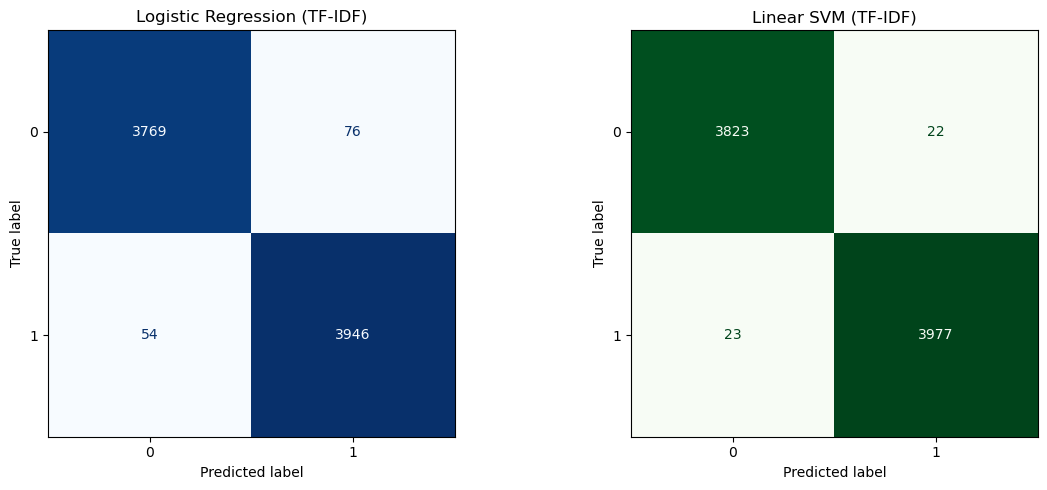

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# --- Train Logistic Regression ---
logreg = LogisticRegression(max_iter=2000, solver="saga", class_weight="balanced", n_jobs=-1)
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

# --- Train Linear SVM ---
svm_model = LinearSVC(class_weight="balanced")
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# --- Print Classification Reports ---
print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred_lr, digits=4))
print("\n=== Linear SVM ===")
print(classification_report(y_test, y_pred_svm, digits=4))

# --- Prepare Confusion Matrices ---
cm_lr = confusion_matrix(y_test, y_pred_lr)
cm_svm = confusion_matrix(y_test, y_pred_svm)

# --- Plot Side-by-Side ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=logreg.classes_)
disp_lr.plot(cmap='Blues', ax=axes[0], colorbar=False)
axes[0].set_title("Logistic Regression (TF-IDF)")

disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=svm_model.classes_)
disp_svm.plot(cmap='Greens', ax=axes[1], colorbar=False)
axes[1].set_title("Linear SVM (TF-IDF)")

plt.tight_layout()
plt.show()

Looking at both confusion matrix, we can see that both models are performing very well 98% accuracy on both. Interesting aspect is that SVM, wins as it has lower false negatives. 

4.5 Representation of metrics with Comparison Bar Plot

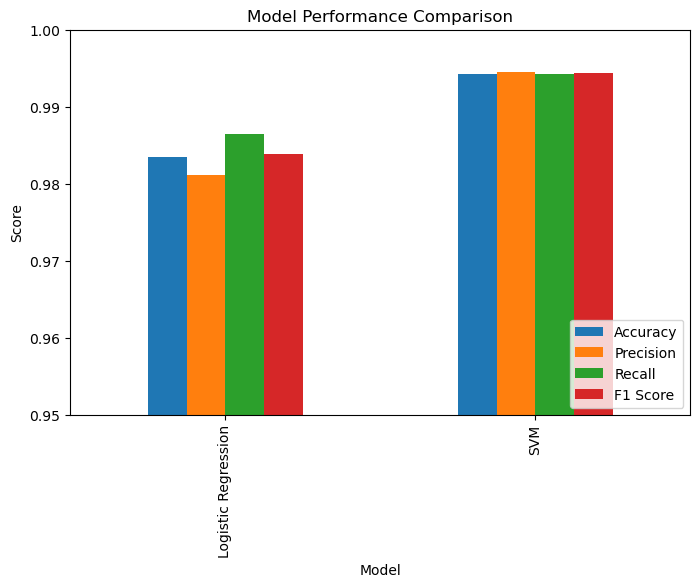

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

metrics = {
    'Model': ['Logistic Regression', 'SVM'],
    'Accuracy': [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_svm)],
    'Precision': [precision_score(y_test, y_pred_lr), precision_score(y_test, y_pred_svm)],
    'Recall': [recall_score(y_test, y_pred_lr), recall_score(y_test, y_pred_svm)],
    'F1 Score': [f1_score(y_test, y_pred_lr), f1_score(y_test, y_pred_svm)]
}

df_metrics = pd.DataFrame(metrics).set_index('Model')
df_metrics.plot(kind='bar', figsize=(8,5))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0.95, 1.0)
plt.legend(loc='lower right')
plt.show()

SVM outpefroms in Accuracy, precision, recall and F1 Score. 

4.6 Saving the Vectorizer

In [14]:
import joblib
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

4.6 Saving the model

In [15]:
import joblib

joblib.dump(logreg, "logistic_regression_tfidf.pkl")
joblib.dump(svm_model, "svm_tfidf.pkl")

print("Models saved successfully!")

Models saved successfully!
